# Library Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")

# Utils

In [31]:
def data_preprocessing(data, product_availability, holidays_events_data, stores_data, oil_data):

    stores_data['country'] = 'Ecuador'

    df_temp = holidays_events_data[holidays_events_data['locale'] == 'Regional']

    df1 = pd.merge(df_temp, stores_data, 
                left_on= 'locale_name',
                right_on=['state'], 
                how='left')

    df_temp = holidays_events_data[holidays_events_data['locale'] == 'Local']
    df2 = pd.merge(df_temp, stores_data, 
                left_on= 'locale_name',
                right_on=['city'], 
                how='left')

    df_temp = holidays_events_data[holidays_events_data['locale'] == 'National']
    df3 = pd.merge(df_temp, stores_data, 
                    how='left',
                    left_on= 'locale_name',
                    right_on=['country'])
    data_holiday = pd.concat([df1, df2, df3], ignore_index=True)

    data_holiday.rename(columns={"type_x": "holiday_type",
                    "type_y": "store_type"}, inplace=True)

    data_holiday.drop(columns=['description', 'locale', 
                    'locale_name', 'city','state','store_type','cluster','country' ], inplace=True)


    data = pd.merge(data, data_holiday, 
                on = ['date', 'store_nbr'], 
                how='left')

    data = pd.merge(data, stores_data,
                    on='store_nbr',
                    how='left')

    data = pd.merge(data, oil_data,
                    on='date',
                    how='left')
    
    data =pd.merge(data, product_availability,
                    on=['store_nbr', 'family'],
                    how='left')
    
    data.rename(columns={"sales_x": "sales"}, inplace=True)
    
    if 'sales_y' in data.columns:
        data.drop(columns=['sales_y'], inplace=True)
    else:
        data.drop(columns=['sales'], inplace=True)

    data = data.sort_values(by='date', ascending=True).reset_index(drop=True)
    data['is_wage_day'] = data['date'].apply(lambda x: True if x.day == 15 or x.day == x.days_in_month else False)

    data['dcoilwtico'] = data['dcoilwtico'].fillna(method='ffill')
    data['transferred'] = data['transferred'].fillna(False)
    data['is_holiday'] = ~data['holiday_type'].isna()
    data['day_of_week'] = data['date'].dt.dayofweek
    data['is_weekend'] = data['day_of_week'].isin([5, 6])
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['day'] = data['date'].dt.day
    data.drop(columns=['country'], inplace=True)

    return data


def codificador(data):
    le = LabelEncoder()
    data['family'] = le.fit_transform(data['family'])
    data['type'] = le.fit_transform(data['type'])
    data['holiday_type'] = le.fit_transform(data['holiday_type'])
    data['city'] = le.fit_transform(data['city'])
    data['state'] = le.fit_transform(data['state'])
    data['is_weekend'] = data['is_weekend'].astype(int)
    data['is_sold'] = data['is_sold'].astype(int)
    data['is_holiday'] = data['is_holiday'].astype(int)
    data['transferred'] = data['transferred'].astype(int)
    return data

# Data loading and first impressions

In [20]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
stores_data = pd.read_csv('data/stores.csv')
oil_data = pd.read_csv('data/oil.csv')
holidays_events_data = pd.read_csv('data/holidays_events.csv')

product_availability = train_data.groupby(['store_nbr', 'family'])['sales'].sum().reset_index()
product_availability['is_sold'] = product_availability.groupby(['store_nbr', 
                                                                'family']
                                                                )['sales'].transform(
                                                                    lambda x: True 
                                                                    if x.sum() > 0 
                                                                    else False
                                                                )

train_data['date'] = pd.to_datetime(train_data['date'])
holidays_events_data['date'] = pd.to_datetime(holidays_events_data['date'])
oil_data['date'] = pd.to_datetime(oil_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])

oil_data['dcoilwtico'][0] = 93.14

print(train_data.head())
print(stores_data.head())
print(oil_data.head())
print(holidays_events_data.head())
print(product_availability.head())


   id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0
1   1 2013-01-01          1   BABY CARE    0.0            0
2   2 2013-01-01          1      BEAUTY    0.0            0
3   3 2013-01-01          1   BEVERAGES    0.0            0
4   4 2013-01-01          1       BOOKS    0.0            0
   store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4
        date  dcoilwtico
0 2013-01-01       93.14
1 2013-01-02       93.14
2 2013-01-03       92.97
3 2013-01-04       93.12
4 2013-01-07       93.20
        date     type    locale locale_name   

# Data preprocessing

In [34]:
df = data_preprocessing(train_data, product_availability, holidays_events_data, stores_data, oil_data)
display(df.head(5))
df_coded = codificador(df)
display(df_coded.head(5))

,id,date,store_nbr,family,sales,onpromotion,holiday_type,transferred,city,state,...,cluster,dcoilwtico,is_sold,is_wage_day,is_holiday,day_of_week,is_weekend,year,month,day
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Holiday,False,Quito,Pichincha,...,13,93.14,True,False,True,1,False,2013,1,1
1,1194,2013-01-01,42,CELEBRATION,0.0,0,Holiday,False,Cuenca,Azuay,...,2,93.14,True,False,True,1,False,2013,1,1
2,1193,2013-01-01,42,BREAD/BAKERY,0.0,0,Holiday,False,Cuenca,Azuay,...,2,93.14,True,False,True,1,False,2013,1,1
3,1192,2013-01-01,42,BOOKS,0.0,0,Holiday,False,Cuenca,Azuay,...,2,93.14,True,False,True,1,False,2013,1,1
4,1191,2013-01-01,42,BEVERAGES,0.0,0,Holiday,False,Cuenca,Azuay,...,2,93.14,True,False,True,1,False,2013,1,1


,id,date,store_nbr,family,sales,onpromotion,holiday_type,transferred,city,state,...,cluster,dcoilwtico,is_sold,is_wage_day,is_holiday,day_of_week,is_weekend,year,month,day
0,0,2013-01-01,1,0,0.0,0,3,0,18,12,...,13,93.14,1,False,1,1,0,2013,1,1
1,1194,2013-01-01,42,6,0.0,0,3,0,3,0,...,2,93.14,1,False,1,1,0,2013,1,1
2,1193,2013-01-01,42,5,0.0,0,3,0,3,0,...,2,93.14,1,False,1,1,0,2013,1,1
3,1192,2013-01-01,42,4,0.0,0,3,0,3,0,...,2,93.14,1,False,1,1,0,2013,1,1
4,1191,2013-01-01,42,3,0.0,0,3,0,3,0,...,2,93.14,1,False,1,1,0,2013,1,1


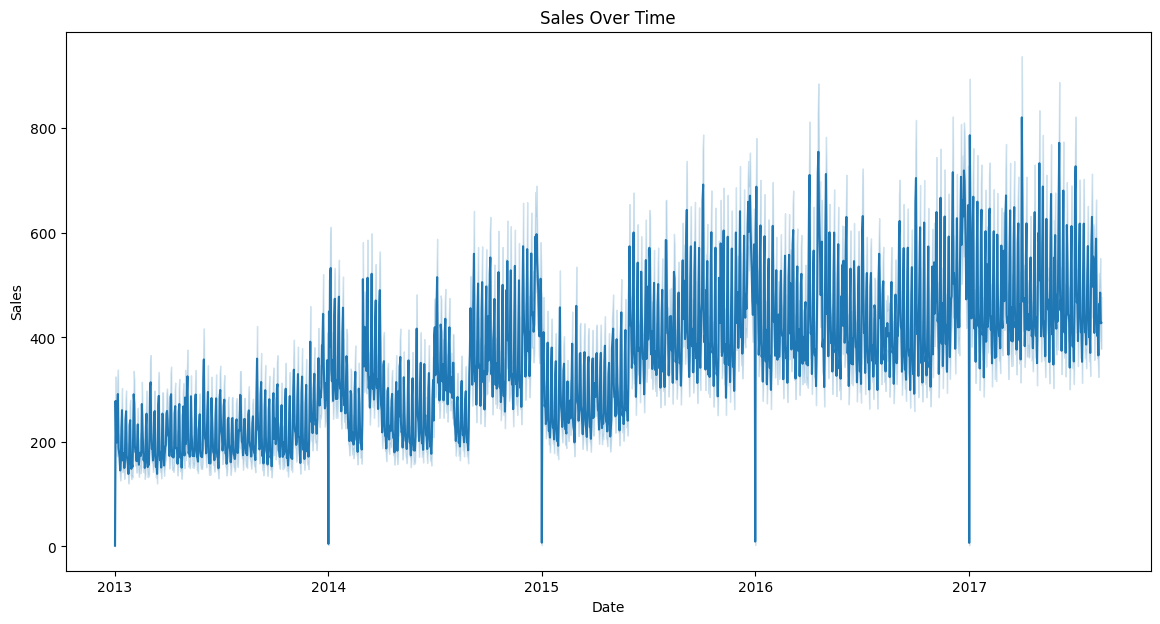

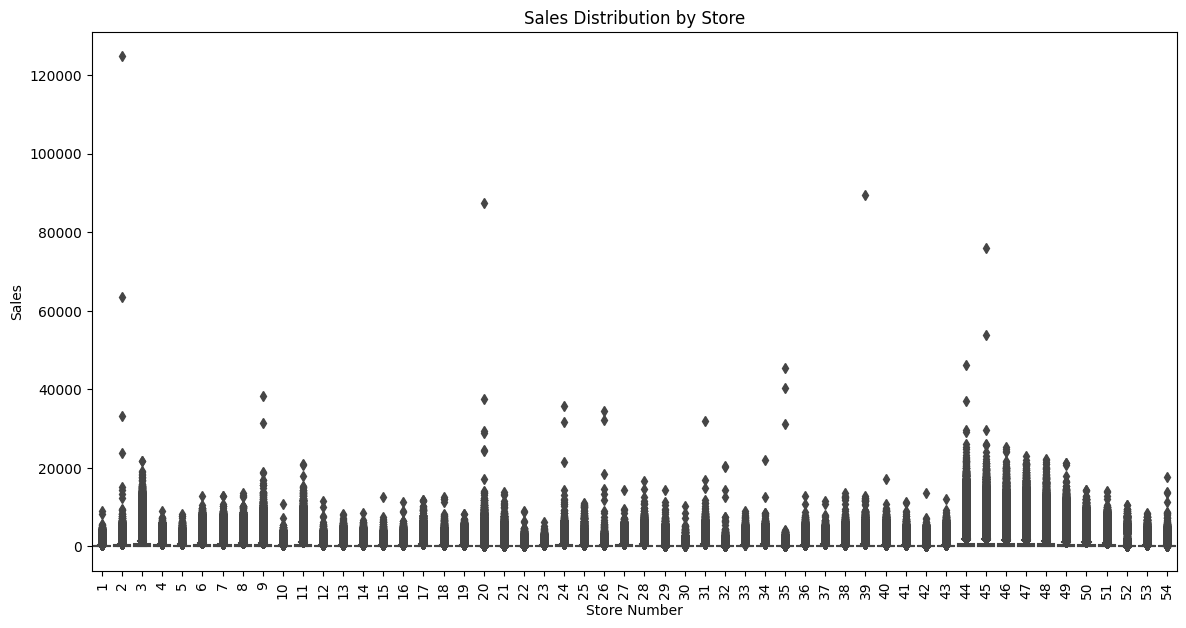

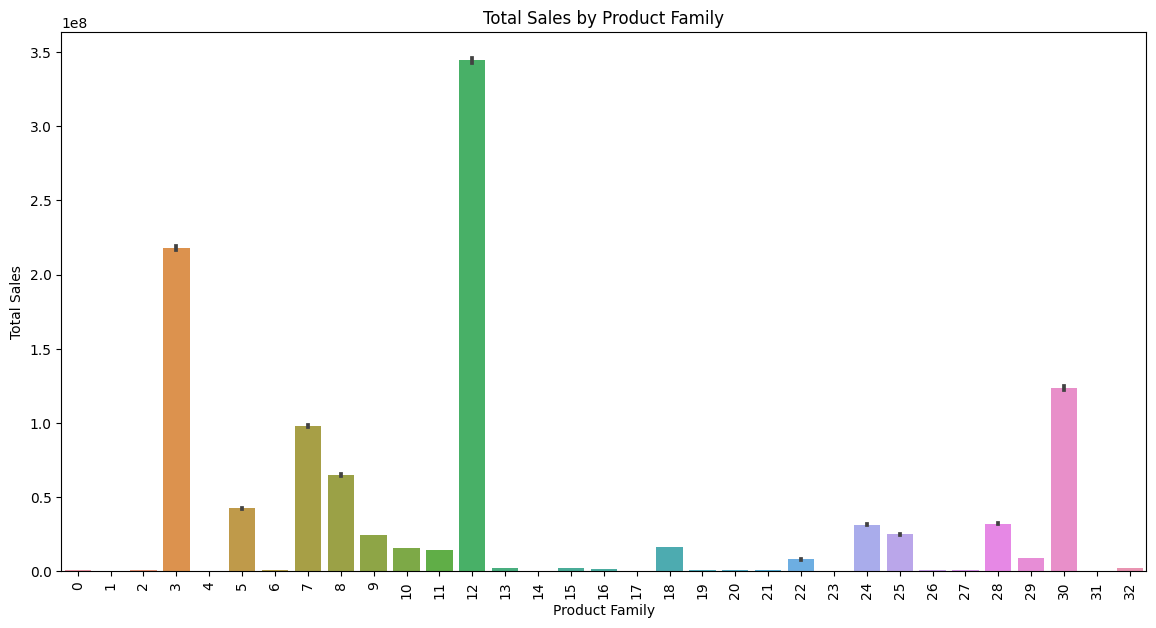

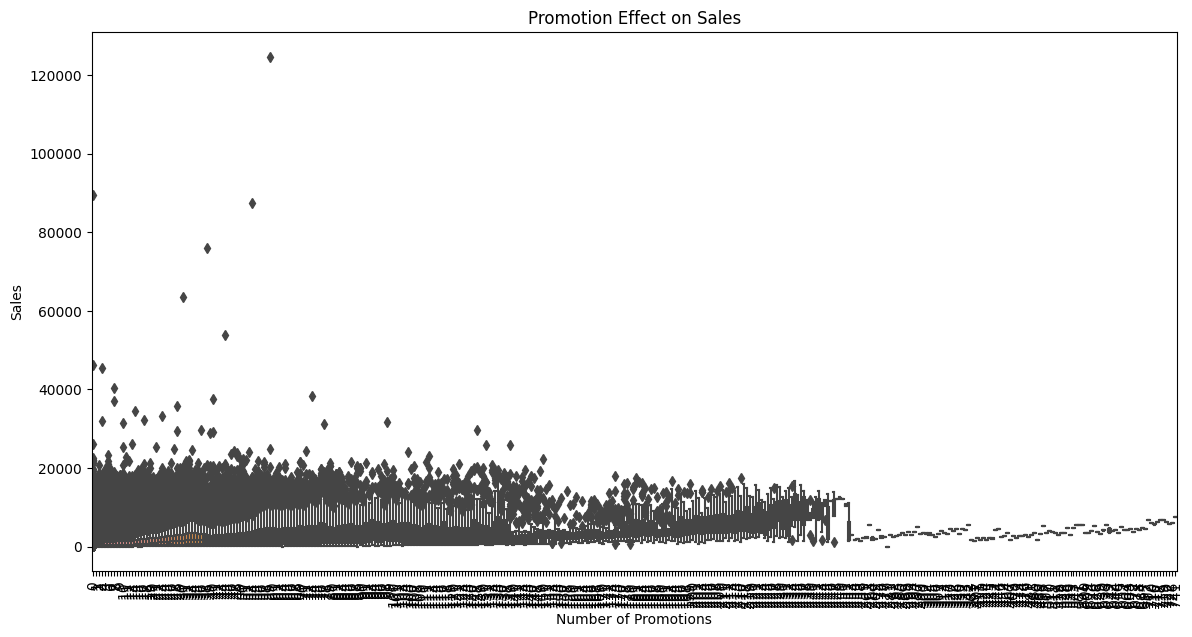

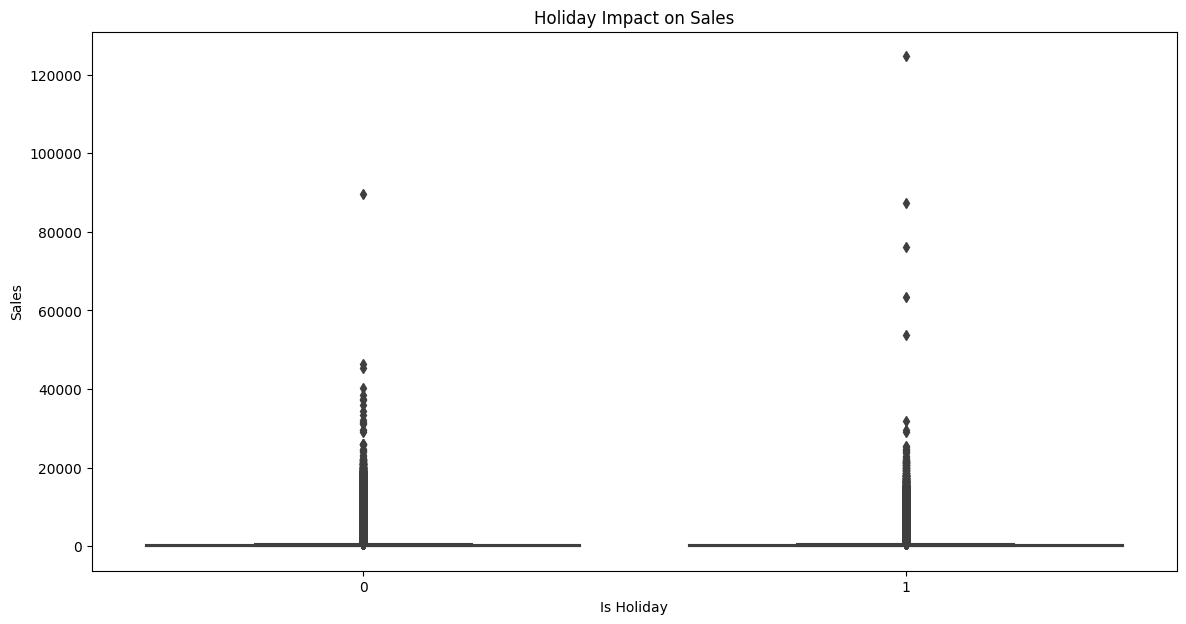

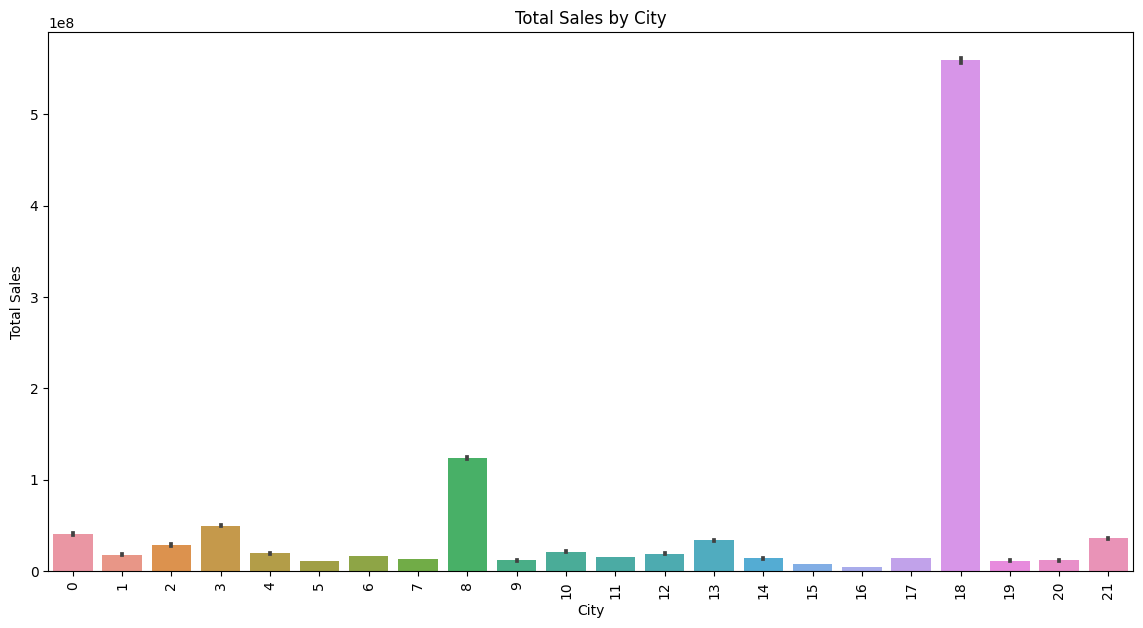

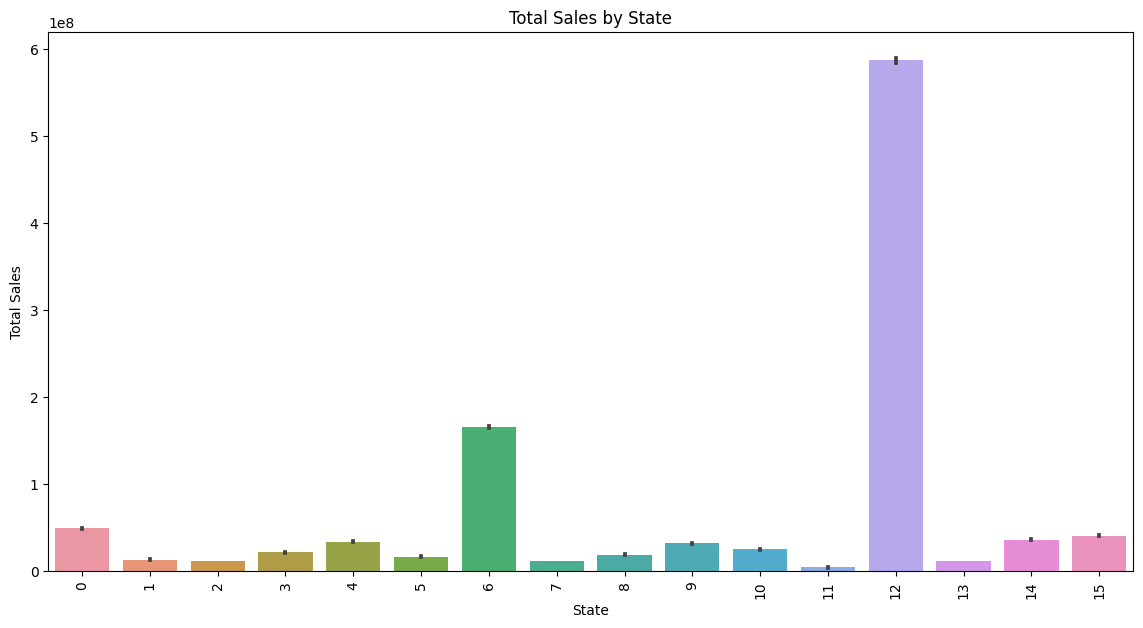

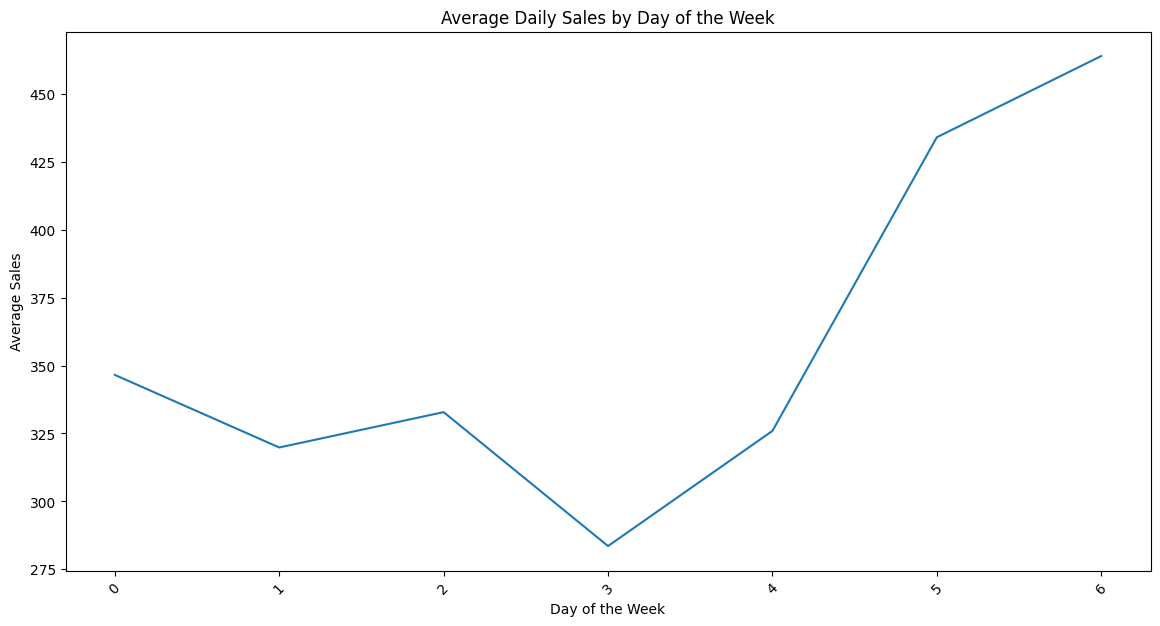

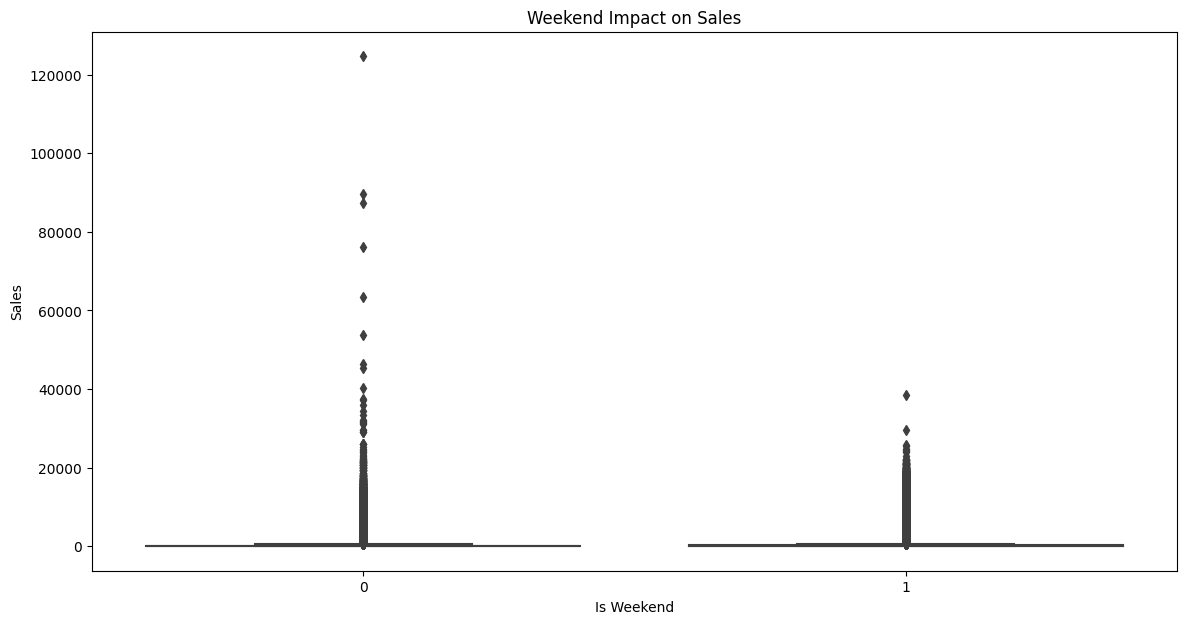

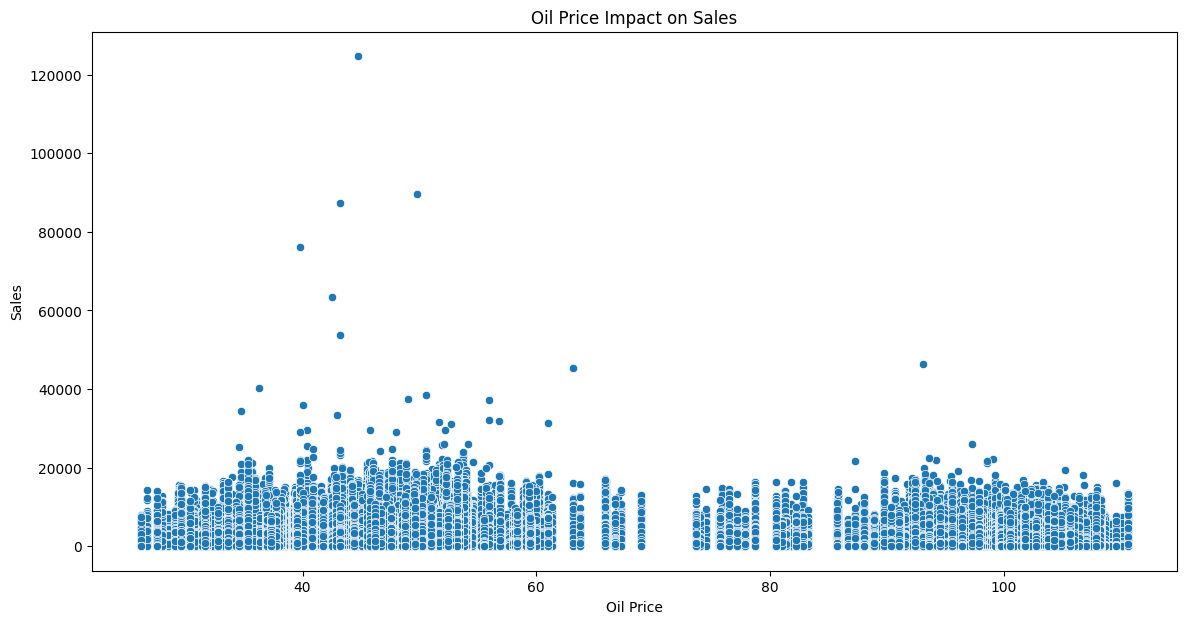

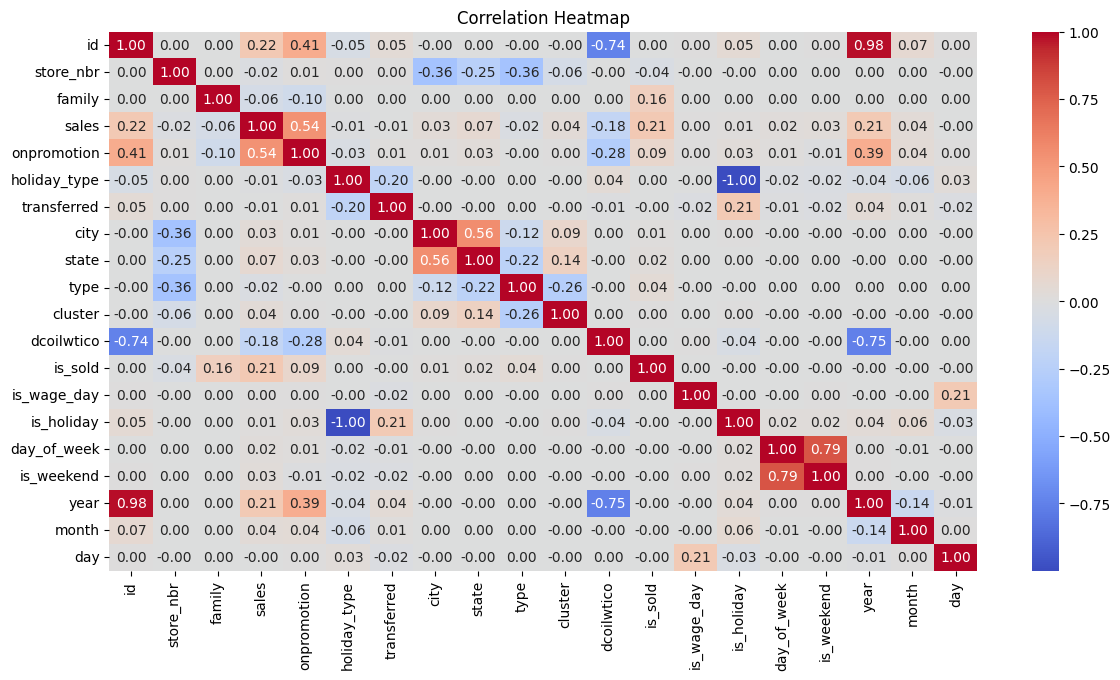

In [6]:
# Plotting Sales Over Time
plt.figure(figsize=(14, 7))
sns.lineplot(x='date', y='sales', data=df[['date', 'sales']])
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

# Sales Distribution by Store
plt.figure(figsize=(14, 7))
sns.boxplot(x='store_nbr', y='sales', data=df[['store_nbr', 'sales']])
plt.title('Sales Distribution by Store')
plt.xlabel('Store Number')
plt.ylabel('Sales')
plt.xticks(rotation=90)
plt.show()

# Sales by Product Family
plt.figure(figsize=(14, 7))
sns.barplot(x='family', y='sales', data=df[['family', 'sales']], estimator=sum)
plt.title('Total Sales by Product Family')
plt.xlabel('Product Family')
plt.ylabel('Total Sales')
plt.xticks(rotation=90)
plt.show()

# Promotion Effect on Sales
plt.figure(figsize=(14, 7))
sns.boxplot(x='onpromotion', y='sales', data=df[['onpromotion', 'sales']])
plt.title('Promotion Effect on Sales')
plt.xlabel('Number of Promotions')
plt.ylabel('Sales')
plt.xticks(rotation=90)
plt.show()

# Holiday Impact on Sales
plt.figure(figsize=(14, 7))
sns.boxplot(x='is_holiday', y='sales', data=df[['is_holiday', 'sales']])
plt.title('Holiday Impact on Sales')
plt.xlabel('Is Holiday')
plt.ylabel('Sales')
plt.show()

# Sales by City
plt.figure(figsize=(14, 7))
sns.barplot(x='city', y='sales', data=df[['city','sales']], estimator=sum)
plt.title('Total Sales by City')
plt.xlabel('City')
plt.ylabel('Total Sales')
plt.xticks(rotation=90)
plt.show()

# Sales by State
plt.figure(figsize=(14, 7))
sns.barplot(x='state', y='sales', data=df[['state','sales']], estimator=sum)
plt.title('Total Sales by State')
plt.xlabel('State')
plt.ylabel('Total Sales')
plt.xticks(rotation=90)
plt.show()

# Average Daily Sales by Day of the Week
plt.figure(figsize=(14, 7))
sns.lineplot(x='day_of_week', y='sales', data=df[['day_of_week','sales']], estimator='mean', ci=None)
plt.title('Average Daily Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.show()

# Weekend Impact on Sales
plt.figure(figsize=(14, 7))
sns.boxplot(x='is_weekend', y='sales', data=df[['is_weekend', 'sales']])
plt.title('Weekend Impact on Sales')
plt.xlabel('Is Weekend')
plt.ylabel('Sales')
plt.show()

# Oil Price Impact on Sales
plt.figure(figsize=(14, 7))
sns.scatterplot(x='dcoilwtico', y='sales', data=df[['dcoilwtico', 'sales']])
plt.title('Oil Price Impact on Sales')
plt.xlabel('Oil Price')
plt.ylabel('Sales')
plt.show()

# Correlation Heatmap
plt.figure(figsize=(14, 7))
corr = df.corr(numeric_only=True, method='spearman')
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


In [ ]:
display(df.head(5))
display(df_coded.head(5))

# First prediction: the total sales of a Store

In [7]:
train = df_coded.drop(columns=['date','is_holiday', 'holiday_type', 'transferred', 
                               'is_holiday','dcoilwtico', 
                               'is_wage_day'])
display(train.head(5))
train = train[train['store_nbr'] == 1].reset_index(drop=True)
train = train.drop(columns=['store_nbr'])

X = train.drop(columns= [ 'id','sales'], axis=1)
y = train['sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

,id,store_nbr,family,sales,onpromotion,city,state,type,cluster,is_sold,day_of_week,is_weekend,year,month,day
0,0,1,0,0.0,0,18,12,3,13,1,1,0,2013,1,1
1,1194,42,6,0.0,0,3,0,3,2,1,1,0,2013,1,1
2,1193,42,5,0.0,0,3,0,3,2,1,1,0,2013,1,1
3,1192,42,4,0.0,0,3,0,3,2,1,1,0,2013,1,1
4,1191,42,3,0.0,0,3,0,3,2,1,1,0,2013,1,1


In [8]:
models = [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    xgb.XGBRegressor(objective ='reg:squarederror')
]
model_params = {}
for model in models:
    model.fit(X_train, y_train)
    scores = cross_val_score(model, X_test, y_test, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    rmse_scores = np.sqrt(-scores)
    print(f"Model: {type(model).__name__}")
    print(f"RMSE Scores: {rmse_scores}")
    print(f"Mean RMSE: {rmse_scores.mean()}\n")
    model_params[type(model).__name__] = model

Model: LinearRegression
RMSE Scores: [495.57770542 491.23568797 501.98225975 508.44616971 505.68125059]
Mean RMSE: 500.5846146869529

Model: DecisionTreeRegressor
RMSE Scores: [164.4777811  202.95324928 168.04377156 236.06810822 193.75234904]
Mean RMSE: 193.05905183692238

Model: RandomForestRegressor
RMSE Scores: [150.24452653 144.13784554 142.08067841 159.73695557 167.84863527]
Mean RMSE: 152.80972826197086

Model: XGBRegressor
RMSE Scores: [139.14096202 159.10088842 147.35500567 163.25099227 175.91255326]
Mean RMSE: 156.95208032807074



## Adding holiday information

In [9]:
train = df_coded.drop(columns=['date','dcoilwtico', 'is_wage_day'])
train = train[train['store_nbr'] == 1].reset_index(drop=True)
train = train.drop(columns=['store_nbr'])
display(train.head(5))

X = train.drop(columns= [ 'id','sales'], axis=1)
y = train['sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

,id,family,sales,onpromotion,holiday_type,transferred,city,state,type,cluster,is_sold,is_holiday,day_of_week,is_weekend,year,month,day
0,0,0,0.0,0,3,0,18,12,3,13,1,1,1,0,2013,1,1
1,24,24,0.0,0,3,0,18,12,3,13,1,1,1,0,2013,1,1
2,23,23,0.0,0,3,0,18,12,3,13,1,1,1,0,2013,1,1
3,22,22,0.0,0,3,0,18,12,3,13,1,1,1,0,2013,1,1
4,21,21,0.0,0,3,0,18,12,3,13,1,1,1,0,2013,1,1


In [10]:
models = [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    xgb.XGBRegressor(objective ='reg:squarederror')
]

model_params = {}
for model in models:
    model.fit(X_train, y_train)
    scores = cross_val_score(model, X_test, y_test, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    rmse_scores = np.sqrt(-scores)
    print(f"Model: {type(model).__name__}")
    print(f"RMSE Scores: {rmse_scores}")
    print(f"Mean RMSE: {rmse_scores.mean()}\n")
    model_params[type(model).__name__] = model

Model: LinearRegression
RMSE Scores: [495.17850705 490.83559681 502.40819177 508.191633   505.55033507]
Mean RMSE: 500.432852739045

Model: DecisionTreeRegressor
RMSE Scores: [184.70000192 230.3124395  156.89075846 239.7046429  176.15641694]
Mean RMSE: 197.55285194420674

Model: RandomForestRegressor
RMSE Scores: [147.31567419 146.43263145 136.49869121 163.31796805 160.0457793 ]
Mean RMSE: 150.7221488395871

Model: XGBRegressor
RMSE Scores: [134.03955793 155.72977172 141.98656186 163.92477524 165.14197337]
Mean RMSE: 152.16452802510273



## Adding oil barrel price information

In [11]:
train = df_coded.drop(columns=['date','is_wage_day'])
train = train[train['store_nbr'] == 1].reset_index(drop=True)
train = train.drop(columns=['store_nbr'])

X = train.drop(columns= [ 'id','sales'], axis=1)
y = train['sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
models = [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    xgb.XGBRegressor(objective ='reg:squarederror')
]

model_params = {}
for model in models:
    model.fit(X_train, y_train)
    scores = cross_val_score(model, X_test, y_test, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    rmse_scores = np.sqrt(-scores)
    print(f"Model: {type(model).__name__}")
    print(f"RMSE Scores: {rmse_scores}")
    print(f"Mean RMSE: {rmse_scores.mean()}\n")
    model_params[type(model).__name__] = model

Model: LinearRegression
RMSE Scores: [494.74496289 490.77902453 502.35261    507.89976088 505.82257987]
Mean RMSE: 500.3197876352442

Model: DecisionTreeRegressor
RMSE Scores: [165.57347858 244.86239198 181.57834874 202.37885618 199.52725213]
Mean RMSE: 198.78406552361355

Model: RandomForestRegressor
RMSE Scores: [145.4329556  151.05306126 149.23564479 166.60130683 162.49456274]
Mean RMSE: 154.96350624367483

Model: XGBRegressor
RMSE Scores: [126.71431363 153.45785408 150.21743912 152.57346943 169.74195848]
Mean RMSE: 150.54100694680378



## Add public wages day

In [13]:
train = df_coded[df_coded['store_nbr'] == 1].reset_index(drop=True)
train = train.drop(columns=['store_nbr'])

X = train.drop(columns= ['date', 'id','sales'], axis=1)
y = train['sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    xgb.XGBRegressor(objective ='reg:squarederror')
]

model_params = {}
for model in models:
    model.fit(X_train, y_train)
    scores = cross_val_score(model, X_test, y_test, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    rmse_scores = np.sqrt(-scores)
    print(f"Model: {type(model).__name__}")
    print(f"RMSE Scores: {rmse_scores}")
    print(f"Mean RMSE: {rmse_scores.mean()}\n")
    model_params[type(model).__name__] = model


Model: LinearRegression
RMSE Scores: [494.72633237 490.78862952 502.3567655  507.87869211 505.86689362]
Mean RMSE: 500.3234626252938

Model: DecisionTreeRegressor
RMSE Scores: [183.41563228 288.84500537 177.67836647 196.24380145 203.89384163]
Mean RMSE: 210.0153294413965

Model: RandomForestRegressor
RMSE Scores: [138.01183978 187.07345156 147.66692419 165.72130705 165.94753646]
Mean RMSE: 160.8842118079511

Model: XGBRegressor
RMSE Scores: [132.85033643 178.11940768 150.26836906 154.57158515 174.1179485 ]
Mean RMSE: 157.98552936331538



# Predicting sales for all stores

In [14]:
train = df_coded.copy()

X = train.drop(columns= ['date','id','sales'], axis=1)
y = train['sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = [
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    xgb.XGBRegressor(objective ='reg:squarederror')
]

model_params = {}
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"Model: {type(model).__name__}")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"R^2 Score: {r2}")
    model_params[type(model).__name__] = model

Model: DecisionTreeRegressor
MAE: 61.679207734325765
MSE: 109088.430538235
RMSE: 330.2853774211553
R^2 Score: 0.909021476077877
Model: RandomForestRegressor
MAE: 46.705336143424525
MSE: 58225.33341291289
RMSE: 241.29926111141097
R^2 Score: 0.9514407269162827
Model: XGBRegressor
MAE: 119.15079062770567
MSE: 107233.79233479613
RMSE: 327.4657116932949
R^2 Score: 0.9105682234765327


# Kaggle submission

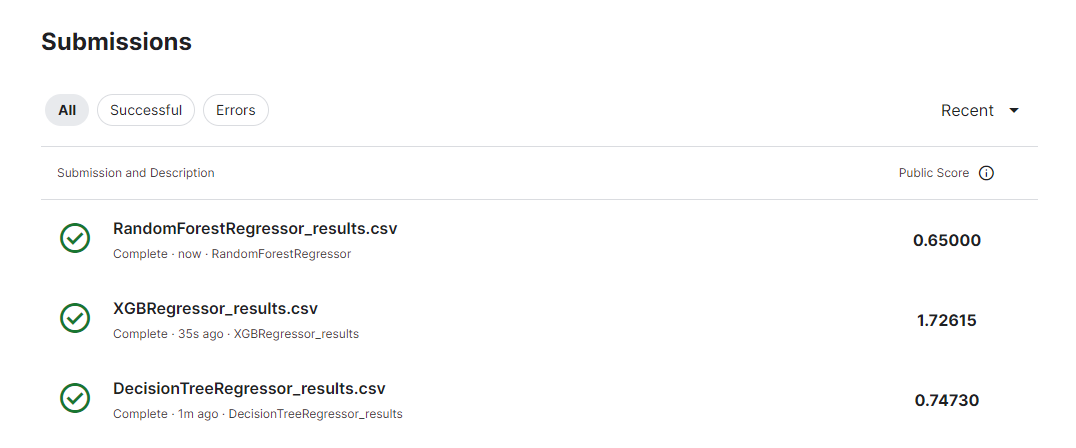

In [33]:
submission = data_preprocessing(test_data, product_availability, holidays_events_data, stores_data, oil_data)
submission = submission.sort_values(by='id', ascending=True).reset_index(drop=True)
submission = codificador(submission)

X_submission = submission.drop(columns=['id', 'date'])
for model in model_params:
    y_submission = model_params[model].predict(X_submission)
    submission_file = pd.DataFrame({'id': submission['id'], 'sales': y_submission})
    submission_file.to_csv(f'results/{model}_results.csv', index=False)

Image(filename='images/kaggle-sales.png')
